__File: quasideuteron.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jan 24, 2022__

Using method from SRC paper to analyze the quasideuteron model and the Levinger constant in connection to GCF papers.

__Revision history:<br/>__
* Jan 26, 2022 - Finished a function that verifies the asymptotic relation between the single-nucleon and pair momentum distributions at high momentum. The function also shows VMC calculations when possible. Also finished a function that plots the ratio of $n_{pn}^A(q)/n_p^d(q)$ relative to the Levinger constant.
* Feb 2, 2022 - Updating figure functions to save to figures/quasideuteron. So far, we can plot the ratio of pn/d momentum distributions, the Levinger constant with respect to A, print a table of Levinger constants, and look at the asymptotic relation between proton and pair momentum distributions. In all cases, we compare to experiment or AV18 VMC calculations when possible.
* Feb 9, 2022 - Updated momentum distributions data to include other phenomenological potentials. This notebook will now work for the following additional potentials: Paris, Bonn, Reid93, Nijmegen I, Nijmegen II, and CD-Bonn.
* Feb 15, 2022 - Checking that RKE N$^4$LO 550 MeV can be roughly connected to RKE N$^4$LO 450 MeV through SRG evolution. Using the deuteron momentum distribution to find the value of $\lambda$ that roughly connects the two potentials, and then checking the corresponding Levinger $pn/d$ ratios.

In [1]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
# Scripts made by A.T.
from densities import load_density
from dmd import deuteron_momentum_distributions
from figures import figures_functions as ff
from misc.integration import gaussian_quadrature_mesh
import observables as ob
from pmd import pair_momentum_distributions
from potentials.vsrg_macos import vnn
from snmd import single_nucleon_momentum_distributions
from srg.srg_unitary_transformation import SRG_unitary_transformation
import time

# Set-up

In [ ]:
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """

    if presentation:
        fontsize = 14
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by A.T.
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)
#     mpl.rcParams['legend.borderaxespad'] = 0.8
    # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['legend.framealpha'] = None
    # This is for legend edgewidth, since it does not have its own option
    mpl.rcParams['patch.linewidth'] = 0.8
    mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [ ]:
# Run this cell to customize matplotlib graphics
setup_rc_params(presentation=True)

In [ ]:
# Save figures in the following directory
figure_directory = 'figures/quasideuteron'

# Load data from the following directories
exp_data_directory = 'data/exp' # Data from experiments
vmc_data_directory = 'data/vmc' # Momentum distributions from VMC

# Channels to include in calculations
channels = ['1S0', '3S1'] # S-waves only
channels_3s1 = ['3S1'] # 3S1-3D1 only
channels_pwaves = ['1S0', '3S1', '3P0', '1P1', '3P1'] # Some P-waves

# Default SRG \lambda value
lamb = 1.35
# Higher \lambda values
lambdas = [2, 3, 6]

# Nuclei from SLy4 densities
nuclei_sly4 = [
    ('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
    ('Ca48', 20, 28), ('Fe56', 26, 30), ('Pb208', 82, 126)
]

# Nuclei from Gogny densities
nuclei_gogny = [
    ('He4', 2, 2), ('Li7', 3, 4), ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8),
    ('Al27', 13, 14), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Ti48', 22, 26),
    ('Fe56', 26, 30), ('Cu63', 29, 34), ('Ag107', 47, 60), ('Sn118', 50, 68),
    ('Ce140', 58, 82), ('Ta181', 73, 108), ('Au197', 79, 118),
    ('Pb208', 82, 126), ('U238', 92, 146)
]

# The following nuclei are a subset of the Gogny densities
# For less cluttered figures
example_nuclei = [
    ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
    ('Fe56', 26, 30), ('Sn118', 50, 68), ('Pb208', 82, 126)
]

# Nuclei corresponding to experimental values of L
nuclei_exp = [
    ('Li7', 3, 4), ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8),
    ('Al27', 13, 14), ('Ca40', 20, 20), ('Ti48', 22, 26), ('Cu63', 29, 34),
    ('Ag107', 47, 60), ('Sn118', 50, 68), ('Ce140', 58, 82),
    ('Ta181', 73, 108), ('Pb208', 82, 126), ('U238', 92, 146)
]

# The Levinger constant

At high energy, the Levinger constant relates the photoabsorption cross sections of a nucleus to a deuteron. Experimental results suggest that the value is constant across the nuclear chart $L \approx 5.50 \pm 0.21$. In the GCF papers, they show that the Levinger constant can be related to the ratio of contacts. Furthermore, at high momentum

\begin{aligned}
\frac{ F_{pn}(A) }{ n_p(d) } \approx L \frac{NZ}{A},
\end{aligned}

where $F_{pn}(A)$ is the relative pair momentum distribution of nucleus $A$ (integrate out $Q$ dependence) and $n_p(d)$ is the proton momentum distribution in deuteron. They present a figure of this ratio and a table with the average value over the range $4$ to $5$ fm$^{-1}$ using VMC momentum distributions.

In our calculation,

\begin{aligned}
F_{pn}(A) \equiv 
    n_{pn}^A(q) \approx 
        |F_{\rm hi}(q)|^2 \int d^3Q \int d^3k |F_{\rm lo}(k)|^2
            \theta( k_F^{\tau} - |\frac{\mathbf{Q}}{2}+\mathbf{k}| )
            \theta( k_F^{\tau'} - |\frac{\mathbf{Q}}{2}-\mathbf{k}| ),
\end{aligned}

and

\begin{aligned}
n_{p}(d) \approx&
    \int d^3K \int d^3k
        \delta U(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|) \delta U^{\dagger}(|\mathbf{q}-\frac{\mathbf{K}}{2}|,k)
            \theta( k_F - |\frac{\mathbf{K}}{2}+\mathbf{k}| )
            \theta( k_F - |\frac{\mathbf{K}}{2}-\mathbf{k}| ) \\
    \approx& |F_{\rm hi}(q)|^2 \int d^3K \int d^3k |F_{\rm lo}(k)|^2
            \theta( k_F - |\frac{\mathbf{K}}{2}+\mathbf{k}| )
            \theta( k_F - |\frac{\mathbf{K}}{2}-\mathbf{k}| ).
\end{aligned}

Therefore, the ratio is given by a mean-field quantity determined by integrals over the Heaviside step functions dependent on Fermi momenta. This is pretty much the same as the $a_2$ calculation.

### Ratio of $pn$ over $d$ distributions

In [ ]:
def plot_levinger_ratio(nuclei, channels, kvnn, lamb, kmax=15.0, kmid=3.0,
                        ntot=120, edf='Gogny', xlim=(0.0, 5.0), ylim=(0, 15)):
    """
    Plot ratios of the proton-neutron pair momentum distribution over the
    deuteron momentum distribution as a function of relative momentum q [fm^-1]
    (where the C.o.M. momentum Q is integrated out). The Levinger constant L is
    indicated by plateaus at high relative momentum scaled by NZ/A.
    
    Parameters
    ----------
    nuclei : list
        List that contains the details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Set relative momentum values over [0, 5] fm^-1
    q_min, q_max, q_step = 0.0, xlim[-1], 0.05
    q_array = np.arange(q_min, q_max + q_step, q_step)
    ntot_q = len(q_array)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Take total only ignoring isolated I, \delta U, \delta U^2
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_array)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    

    # --- Loop over nuclei and calculate ratio --- #
    
    # Store ratios in dictionary with nucleus name as key
    d = {}
    for nucleus in nuclei:
        
        # Details of the nucleus
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N+Z
    
        # Try using interpolated pair momentum distribution first
        try:
    
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Need to generate files first
        except OSError:
    
            t0 = time.time()
            pmd.write_file(nucleus_name, 'pn', Z, N, edf)
            t1 = time.time()
            mins = (t1-t0)/60
            print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
            # Now get interpolated version
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
        n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of 2 for pn+np

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
        # Calculate ratio and store in dictionary
        ratio_array = A/(N*Z) * n_pn_array / n_d_array
        d[nucleus_name] = ratio_array

    # Set-up average value of L
    L_mean = 5.5
    L_sig = 0.21
    
    # Convert L +/- L_sigma to arrays for errorbands
    L_upper_array = np.ones(ntot_q) * (L_mean + L_sig)
    L_lower_array = np.ones(ntot_q) * (L_mean - L_sig)
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$\frac{A}{NZ} \frac{ n_{pn}^A(q) }{ n_{p}^d(q) }$'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Add Levinger constant to figure (L = 5.5 +/- 0.21)
    ax.axhline(y=L_mean, label='L', color='xkcd:black', linestyle='dotted')
    ax.fill_between(q_array, y1=L_lower_array, y2=L_upper_array,
                    color='xkcd:black', alpha=0.3)

    # Add ratios to plot
    for i, nucleus in enumerate(nuclei):
        
        # Name of nucleus (e.g., 'C12')
        nucleus_name = nucleus[0]
        ratio_array = d[nucleus_name]
        
        # Add nucleus to legend
        curve_label = ff.nuclei_label_conversion(nucleus_name)
        
        # Set color
        curve_color = ff.xkcd_colors(i+1) # Skip black
        
        ax.plot(q_array, ratio_array, label=curve_label, linewidth=curve_width,
                color=curve_color)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

In [ ]:
# AV18 with Gogny (not all in L plot)

kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# AV18 with SLy4

kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'SLY4'

f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'SLy4'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in nuclei_sly4:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# GT+ N2LO 1 fm

kvnn = 222
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# GT+ N2LO 1.2 fm

kvnn = 224
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# RKE N4LO 450 MeV

kvnn = 111
kmax, kmid, ntot = 10.0, 2.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# RKE N4LO 550 MeV

kvnn = 113
kmax, kmid, ntot = 10.0, 2.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# Nijmegen II

kvnn = 5
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# CD-Bonn

kvnn = 7
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

### Table of average $L$ values

In [ ]:
def levinger_constant_table(q_range, nuclei, channels, kvnn, lamb, kmax=15.0,
                            kmid=3.0, ntot=120, edf='Gogny'):
    """
    Compute the average L value associated with the ratio of the proton-neutron
    pair momentum distribution over the deuteron momentum distribution as a
    function of relative momentum q [fm^-1] (where the C.o.M. momentum Q is
    integrated out). Here we average over some relative momentum range (as in
    Weiss et al., https://arxiv.org/pdf/1503.07047.pdf).
    
    Parameters
    ----------
    q_range : 1-D ndarray
        Array of momentum values to average L over [fm^-1].
    nuclei : list
        List that contains the details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').

    """
    
    # --- Set-up --- #
    
    # Get number of q points
    ntot_q = len(q_range)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_range, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_range, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Take total only and ignore the isolated terms
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_range)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    

    # --- Loop over nuclei and print --- #
    
    # Print header
    print('-'*79)
    print(f'Computing L for kvnn = {kvnn} and EDF = {edf}')
    print(
        f'Averaging over q from {min(q_range):.1f} to {max(q_range):.1f} fm^-1'
    )
    
    for nucleus in nuclei:
        
        # Details of the nucleus
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N+Z
    
        # Try using interpolated pair momentum distribution first
        try:
    
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Need to generate files first
        except OSError:
    
            t0 = time.time()
            pmd.write_file(nucleus_name, 'pn', Z, N, edf)
            t1 = time.time()
            mins = (t1-t0)/60
            print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
            # Now get interpolated version
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
        n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of 2 for pn+np

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1) 
    
        # Get mean value of ratio over momentum range and print results
        ratio_array = A/(N*Z) * n_pn_array / n_d_array
        L_avg = np.mean(ratio_array)
        
        print(f'Nucleus = {nucleus_name}, L = {L_avg:.2f}')

In [ ]:
# AV18 with Gogny (default)

kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 4.0, 5.0, 0.1
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [ ]:
# AV18 but averaging at lower q values
# Taking average over 2.6 to 3.3 fm^-1

kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [ ]:
# GT+ N2LO 1 fm

kvnn = 222
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [ ]:
# GT+ N2LO 1.2 fm

kvnn = 224
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [ ]:
# RKE N4LO 450 MeV

kvnn = 111
kmax, kmid, ntot = 10.0, 2.0, 120
edf = 'Gogny'

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [ ]:
# RKE N4LO 550 MeV

kvnn = 113
kmax, kmid, ntot = 10.0, 2.0, 120
edf = 'Gogny'

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [ ]:
# Nijmegen II

kvnn = 5
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 4.0, 5.0, 0.1
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

In [ ]:
# CD-Bonn

kvnn = 7
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 4.0, 5.0, 0.1
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_exp, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

### Compare average $L$ values to experiment

In [ ]:
def plot_levinger_constant_exp(
        q_range, nuclei, channels, kvnn, lamb, kmax=15.0, kid=3.0, ntot=120,
        edf='Gogny', xlim=(5e0, 3e2), ylim=(0.0, 10.0)):
    """
    Plot the average Levinger constant values L associated with the ratio of
    pn/d momentum distributions with respect to mass number A. Compare to
    experimental data.
    
    Parameters
    ----------
    q_range : 1-D ndarray
        Array of momentum values to average L over [fm^-1].
    nuclei : list
        List that contains the details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Get number of nuclei
    ntot_A = len(nuclei)
    
    # Get number of q points
    ntot_q = len(q_range)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_range, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_range, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Ignore the 1, \delta U, and \delta U^2 isolated contributions
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_range)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    
    # Initialize arrays to store A and L
    A_array = np.zeros(ntot_A)
    L_array = np.zeros(ntot_A)
    
            
    # --- Loop over nuclei and calculate --- #
    for i, nucleus in enumerate(nuclei):
        
        # Details of the nucleus
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N+Z
            
        # Add A value to array
        A_array[i] = A
    
        # Try using interpolated pair momentum distribution first
        try:
    
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Need to generate files first
        except OSError:
    
            t0 = time.time()
            pmd.write_file(nucleus_name, 'pn', Z, N, edf)
            t1 = time.time()
            mins = (t1-t0)/60
            print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
            # Now get interpolated version
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
        # Factor of 2 for pn+np
        n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh)

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
        # Get mean value of ratio over q_range
        ratio_array = A/(N*Z) * n_pn_array / n_d_array
        L_array[i] = np.mean(ratio_array)

        
    # --- Experimental values --- #
    
    data_ahr = np.loadtxt(
        exp_data_directory + '/' + \
        'Ahrens_L_Li7_Be9_C12_O16_Al27_Ca40.txt'
        )
    A_ahr_array = data_ahr[:, 0]
    L_ahr_array = data_ahr[:, 1]
    L_errors_ahr_array = np.array([ data_ahr[:, 2], data_ahr[:, 3] ])
    
    data_sti = np.loadtxt(
        exp_data_directory + '/' + \
        'Stibunov_L_C12_Al27_Ti48_Cu63_Ag107_Sn118_Pb208.txt'
        )
    A_sti_array = data_sti[:, 0]
    L_sti_array = data_sti[:, 1]
    L_errors_sti_array = np.array([ data_sti[:, 2], data_sti[:, 3] ])
    
    data_lep = np.loadtxt(
        exp_data_directory + '/' + \
        'Lepretre_L_Sn118_Ce140_Ta181_Pb208_U238.txt'
        )
    A_lep_array = data_lep[:, 0]
    L_lep_array = data_lep[:, 1]
    L_errors_lep_array = np.array([ data_lep[:, 2], data_lep[:, 3] ])

    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 16
    y_label = 'L'
    y_label_size = 16

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set log-scale on x-axis
    ax.set_xscale('log')
    
    # Experimental values
    ax.errorbar(A_ahr_array, L_ahr_array, yerr=L_errors_ahr_array,
                color='xkcd:red', marker='o', linestyle='', markersize=6,
                label='Ahrens')
    ax.errorbar(A_sti_array, L_sti_array, yerr=L_errors_sti_array,
                color='xkcd:green', marker='d', linestyle='', markersize=6,
                label='Stibunov')
    ax.errorbar(A_lep_array, L_lep_array, yerr=L_errors_lep_array,
                color='xkcd:blue', marker='s', linestyle='', markersize=6,
                label='Lepretre')
    
    # Set curve label as potential
    curve_label = f'{ff.kvnn_label_conversion(kvnn)}'

    # Plot all your values at the same time (same markers and color)
    # Offset A by a bit so you can compare results
    ax.plot(A_array, L_array, color='xkcd:black', marker='^', linestyle='',
            markersize=6, label=curve_label)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

In [ ]:
# Levinger values comparing default case (AV18 + Gogny) to experiment

kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 4.0, 5.0, 0.1
q_range = np.arange(q_min, q_max + q_step, q_step)

f, ax = plot_levinger_constant_exp(q_range, nuclei_exp, channels, kvnn, lamb,
                                   kmax, kmid, ntot, edf)

# Add legend
legend_size = 13
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_constant_exp'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}'
# Add q interval for averaging L to file name
file_name += f'_qmin_{q_min:.1f}_qmax_{q_max:.1f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# Levinger values comparing default case (AV18 + Gogny) to experiment but
# with a lower momentum range in averaging L

kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

# Set relative momentum values over a lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

f, ax = plot_levinger_constant_exp(q_range, nuclei_exp, channels, kvnn, lamb,
                                   kmax, kmid, ntot, edf)

# Add legend
legend_size = 13
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_constant_exp'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}'
# Add q interval for averaging L to file name
file_name += f'_qmin_{q_min:.1f}_qmax_{q_max:.1f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

### Compare average $L$ values between different interactions

In [ ]:
def plot_levinger_constant_vary_kvnn(
        q_range, nuclei, channels, kvnns, lamb, edf='Gogny', xlim=(5e0, 3e2),
        ylim=(0.0, 10.0)):
    """
    Plot the average Levinger constant values L associated with the ratio of
    pn/d momentum distributions with respect to mass number A. Compare to
    experimental data.
    
    Parameters
    ----------
    q_range : 1-D ndarray
        Array of momentum values to average L over [fm^-1].
    nuclei : list
        List that contains the details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnns : list
        List of kvnn numbers which specify the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Get number of nuclei
    ntot_A = len(nuclei)
    
    # Get number of q points
    ntot_q = len(q_range)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_range, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_range, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Store arrays of L in dictionary with kvnn as the key
    d = {}
    
            
    # --- Loop over kvnn, nuclei and calculate --- #
    for kvnn in kvnns:
        
        d[kvnn] = {}
        
        # Initialize arrays for A and L
        A_array = np.zeros(ntot_A)
        L_array = np.zeros(ntot_A)
        
        # Get default momentum mesh
        if kvnn < 10 or kvnn > 200:
            kmax, kmid, ntot = 15.0, 3.0, 120
        else:
            kmax, kmid, ntot = 10.0, 2.0, 120
        
        # Initialize deuteron momentum distribution class
        dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                              interp=True)
    
        # Get interpolated functions of deuteron momentum distribution
        # Ignore the 1, \delta U, and \delta U^2 isolated contributions
        n_d_func, _, _, _ = dmd.n_lambda_interp()
    
        # Calculate deuteron momentum distribution
        n_d_array = n_d_func(q_range)
    
        # Initialize pair momentum distribution class
        pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
        
        for j, nucleus in enumerate(nuclei):
        
            # Details of the nucleus
            nucleus_name = nucleus[0]
            Z = nucleus[1]
            N = nucleus[2]
            A = N+Z
            
            # Add A value to array
            A_array[j] = A
    
            # Try using interpolated pair momentum distribution first
            try:
    
                n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z,
                                                         N, edf)

            # Need to generate files first
            except OSError:
    
                t0 = time.time()
                pmd.write_file(nucleus_name, 'pn', Z, N, edf)
                t1 = time.time()
                mins = (t1-t0)/60
                print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
                # Now get interpolated version
                n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z,
                                                         N, edf)

            # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
            # Factor of 2 for pn+np
            n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh)

            # Integrate out Q dependence where
            # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
            n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
            # Get mean value of ratio over q_range
            ratio_array = A/(N*Z) * n_pn_array / n_d_array
            L_array[j] = np.mean(ratio_array)
            
        # Add to dictionary
        d[kvnn]['A_array'] = A_array
        d[kvnn]['L_array'] = L_array
        
        
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 16
    y_label = 'L'
    y_label_size = 16

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set log-scale on x-axis
    ax.set_xscale('log')

    # Loop over kvnns
    for i, kvnn in enumerate(kvnns):
    
        # Curve label should be potential
        curve_label = ff.kvnn_label_conversion(kvnn)
        
        # Set marker color
        marker_color = ff.xkcd_colors(i)
        
        # Set marker shape?

        ax.plot(d[kvnn]['A_array'], d[kvnn]['L_array'], color=marker_color,
                marker='.', linestyle='', label=curve_label)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

In [ ]:
# Levinger values comparing Gogny with Nijmegen II, AV18, CD-Bonn, RKE N4LO
# 450 MeV and 550 MeV, and GT+ N2LO 1 and 1.2 fm

kvnns = [5, 6, 7, 111, 113, 222, 224]
edf = 'Gogny'

# Set relative momentum values over a lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

f, ax = plot_levinger_constant_vary_kvnn(q_range, nuclei_exp, channels, kvnns,
                                         lamb, edf)

# Add legend
# legend_size = 12
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#           fontsize=legend_size)
legend_size = 7
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_constant'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnns'
for ikvnn in kvnns:
    file_name += f'_{ikvnn}'
file_name += f'_lamb_{lamb:.2f}'
# Add q interval for averaging L to file name
file_name += f'_qmin_{q_min:.1f}_qmax_{q_max:.1f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

# Connecting different EFT regulator cutoff scales with the SRG

In [6]:
# Could easily make this with respect to lambda_array and plot for several
# \lambda values
def regulator_cutoff_under_srg(
        kvnn_low, kvnn_high, lambda_match, kmax=15.0, kmid=3.0, ntot=120,
        xlim=(0, 6), ylim=(1e-6, 1e3)):
    """
    Evolve one potential at a higher regulator cutoff to roughly match at a
    lower regulator cutoff. Compare deuteron momentum distributions to get the
    correct matching scale.
    
    Parameters
    ----------
    kvnn_low : int
        This number specifies the lower regulator cutoff potential.
    kvnn_high : int
        This number specifies the higher regulator cutoff potential.
    lambda_match : float
        SRG \lambda parameter where the potentials match [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # The momentum mesh should be the same between both potentials
    q_array, q_weights = vnn.load_momentum(kvnn_low, '3S1', kmax, kmid, ntot)
    # Units of factor_array are fm^-3/2
    factor_array = np.concatenate( (np.sqrt(2/np.pi * q_weights) * q_array,
                                    np.sqrt(2/np.pi * q_weights) * q_array ) )

    # Initial 3S1-3D1 potential for lower cutoff
    H_low_init = vnn.load_hamiltonian(kvnn_low, '3S1', kmax, kmid, ntot)
    # Initial 3S1-3D1 potential for higher cutoff
    H_high_init = vnn.load_hamiltonian(kvnn_high, '3S1', kmax, kmid, ntot)
    # Evolved 3S1-3D1 potential for higher cutoff
    H_high_srg = vnn.load_hamiltonian(kvnn_high, '3S1', kmax, kmid, ntot,
                                      'srg', 'Wegner', lambda_match)

    # Get SRG transformation connecting the two potentials
    U_matrix = SRG_unitary_transformation(H_high_init, H_high_srg)

    # Get deuteron wave function squared for the three cases
    
    # Initial and low cutoff
    wf_low_unitless = ob.wave_function(H_low_init)
    wf_low_init = wf_low_unitless / factor_array
    n_d_low_init = wf_low_init[:ntot]**2 + wf_low_init[ntot:]**2
    
    # Initial and high cutoff
    wf_high_unitless = ob.wave_function(H_high_init)
    wf_high_init = wf_high_unitless / factor_array
    n_d_high_init = wf_high_init[:ntot]**2 + wf_high_init[ntot:]**2
    
    # SRG-evolved and high cutoff
    wf_high_srg = (U_matrix @ wf_high_unitless) / factor_array
    n_d_high_srg = wf_high_srg[:ntot]**2 + wf_high_srg[ntot:]**2
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = '$n_d(q)$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set y-axis to log scale
    ax.set_yscale('log')

    # Initial and high cutoff
    ax.plot(q_array, n_d_high_init, label=ff.kvnn_label_conversion(kvnn_high),
            linewidth=curve_width, linestyle='solid', color='xkcd:black')
    
    # Initial and low cutoff
    ax.plot(q_array, n_d_low_init, label=ff.kvnn_label_conversion(kvnn_low),
            linewidth=curve_width, linestyle='solid', color='xkcd:blue')
    
    # SRG-evolved and high cutoff
    ax.plot(q_array, n_d_high_srg, linewidth=curve_width, color='xkcd:red',
            linestyle='dashed', 
            label=ff.lambda_label_conversion(lambda_match))

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

In [ ]:
# Evolve RKE N4LO 550 MeV to the 450 MeV version with the SRG
# Use deuteron momentum distribution to compare

kvnn_low = 111 # 450 MeV
kvnn_high = 113 # 550 MeV

# Momentum mesh for these potentials
kmax, kmid, ntot = 10.0, 2.0, 120

# \lambda value where they match
lambda_match = 4.5 # fm^-1

f, ax = regulator_cutoff_under_srg(kvnn_low, kvnn_high, lambda_match,
                                   kmax, kmid, ntot)

# Add legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'regulator_cutoff_under_srg' + \
    f'_kvnn_low_{kvnn_low}_kvnn_high_{kvnn_high}' + \
    f'_lambda_match_{lambda_match:.2f}_kmax_{kmax:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# # Same idea but go from AV18 to RKE N4LO 550 MeV

# kvnn_low = 113 # 550 MeV
# kvnn_high = 6 # AV18

# # Momentum mesh for these potentials
# kmax, kmid, ntot = 10.0, 2.0, 120 # YOU NEED RKE ON THE 15 kmax MESH

# # \lambda value where they match
# lambda_match = 4.5 # fm^-1

# f, ax = regulator_cutoff_under_srg(kvnn_low, kvnn_high, lambda_match,
#                                    kmax, kmid, ntot)

# # Add legend
# legend_size = 13
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

In [ ]:
# Same idea but go from AV18 to RKE N4LO 450 MeV

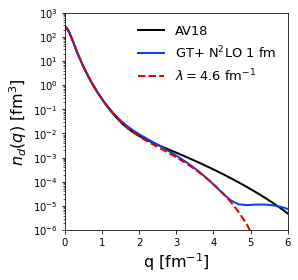

In [13]:
# Same idea but go from AV18 to GT+ 1 fm

kvnn_low = 222 # 550 MeV
kvnn_high = 6 # AV18

# Momentum mesh for these potentials
kmax, kmid, ntot = 15.0, 3.0, 120

# \lambda value where they match
lambda_match = 4.6 # fm^-1

f, ax = regulator_cutoff_under_srg(kvnn_low, kvnn_high, lambda_match,
                                   kmax, kmid, ntot)

# Add legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size);

In [ ]:
def levinger_ratio_regulator_cutoff_compare(
        nucleus, kvnn_low, kvnn_high, lambda_match, lamb, kmax=15.0, kmid=3.0,
        ntot=120, edf='Gogny', xlim=(0, 5), ylim=(0.0, 15.0)):
    """
    Compare the proton-neutron over deuteron momentum distributions ratio
    between two potentials at different regulator cutoffs where we evolve the
    higher of the two to match the lower scale using an SRG transformation.
    Here we treat the Hamiltonian evolved to lambda_match as the initial
    Hamiltonian. Then we compute the momentum distributions taking the
    Hamiltonian evolved to lamb as the evolved Hamiltonian.

    Parameters
    ----------
    nucleus : tuple
        Details for some nucleus formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
    kvnn_low : int
        This number specifies the lower regulator cutoff potential.
    kvnn_high : int
        This number specifies the higher regulator cutoff potential.
    lambda_match : float
        SRG \lambda parameter where the potentials match [fm^-1].
    lamb : float
        SRG \lambda parameter for low RG resolution scale [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Details of the nucleus
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    N = nucleus[2]
    A = N+Z
    
    # Get nucleonic densities
    R_array, rho_p_array = load_density(nucleus_name, 'proton', Z, N, edf)
    R_array, rho_n_array = load_density(nucleus_name, 'neutron', Z, N, edf)
    dR = R_array[2] - R_array[1] # Assuming linear spacing
    
    # Set relative momentum values over [0, 5] fm^-1
    q_min, q_max, q_step = 0.0, xlim[-1], 0.05
    q_array = np.arange(q_min, q_max + q_step, q_step)
    ntot_q = len(q_array)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    
    # --- Calculate for low regulator cutoff first --- #
    
    # Initialize deuteron momentum distribution class
    dmd_low_init = deuteron_momentum_distributions(kvnn_low, lamb, kmax, kmid,
                                                   ntot, interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Take total only ignoring isolated I, \delta U, \delta U^2
    n_d_low_init_func, _, _, _ = dmd_low_init.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_low_init_array = n_d_low_init_func(q_array)
    
    # Initialize pair momentum distribution class
    pmd_low_init = pair_momentum_distributions(kvnn_low, channels, lamb, kmax,
                                               kmid, ntot, interp=True)
    
    # Get interpolated function of pair momentum distribution
    n_pn_low_init_func, _, _, _ = pmd_low_init.n_lambda_interp(nucleus_name,
                                                               'pn', Z, N,
                                                               edf)

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_low_init_array_2d = 2*n_pn_low_init_func.ev(q_mesh, Q_mesh)
    
    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_low_init_array = factor * np.sum(dQ_mesh * n_pn_low_init_array_2d,
                                          axis=-1)
    
    # Calculate ratio
    ratio_low_init_array = A/(N*Z) * n_pn_low_init_array / n_d_low_init_array
    
    
    # --- Calculate for high regulator cutoff --- #
    
    # Initialize deuteron momentum distribution class
    dmd_high_init = deuteron_momentum_distributions(kvnn_high, lamb, kmax,
                                                    kmid, ntot, interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Take total only ignoring isolated I, \delta U, \delta U^2
    n_d_high_init_func, _, _, _ = dmd_high_init.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_high_init_array = n_d_high_init_func(q_array)
    
    # Initialize pair momentum distribution class
    pmd_high_init = pair_momentum_distributions(kvnn_high, channels, lamb,
                                                kmax, kmid, ntot, interp=True)
    
    # Get interpolated function of pair momentum distribution
    n_pn_high_init_func, _, _, _ = pmd_high_init.n_lambda_interp(nucleus_name,
                                                                 'pn', Z, N,
                                                                 edf)

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_high_init_array_2d = 2*n_pn_high_init_func.ev(q_mesh, Q_mesh)
    
    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_high_init_array = factor * np.sum(dQ_mesh * n_pn_high_init_array_2d,
                                           axis=-1)
    
    # Calculate ratio
    ratio_high_init_array = A/(N*Z) * \
                            n_pn_high_init_array / n_d_high_init_array
    
    
    # --- Calculate for high regulator cutoff with SRG starting point --- #
    
    # Initialize deuteron momentum distribution class
    dmd_high_srg = deuteron_momentum_distributions(kvnn_high, lamb, kmax,
                                                   kmid, ntot, interp=False,
                                                   lambda_init=lambda_match)
    
    # Calculate deuteron momentum distribution
    n_d_high_srg_array = dmd_high_srg.n_total(q_array, R_array, dR)
    
    # Initialize pair momentum distribution class
    pmd_high_srg = pair_momentum_distributions(kvnn_high, channels, lamb,
                                               kmax, kmid, ntot, interp=False,
                                               lambda_init=lambda_match)

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_high_srg_array_2d = 2*pmd_high_srg.n_total(q_array, Q_array, R_array,
                                                    dR, rho_p_array, 
                                                    rho_n_array)
    
    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_high_srg_array = factor * np.sum(dQ_mesh * n_pn_high_srg_array_2d,
                                          axis=-1)
    
    # Calculate ratio
    ratio_high_srg_array = A/(N*Z) * n_pn_high_srg_array / n_d_high_srg_array

    
    # --- Plot --- #
    
    # Set-up average value of L
    L_mean = 5.5
    L_sig = 0.21
    
    # Convert L +/- L_sigma to arrays for errorbands
    L_upper_array = np.ones(ntot_q) * (L_mean + L_sig)
    L_lower_array = np.ones(ntot_q) * (L_mean - L_sig)
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$\frac{A}{NZ} \frac{ n_{pn}^A(q) }{ n_{p}^d(q) }$'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Add Levinger constant to figure (L = 5.5 +/- 0.21)
    ax.fill_between(q_array, y1=L_lower_array, y2=L_upper_array,
                    color='xkcd:gray', alpha=0.8)
    
    # Initial and high cutoff
    ax.plot(q_array, ratio_high_init_array, linewidth=curve_width,
            color='xkcd:black', linestyle='solid',
            label=ff.kvnn_label_conversion(kvnn_high))
    
    # Initial and low cutoff
    ax.plot(q_array, ratio_low_init_array, linewidth=curve_width,
            color='xkcd:blue', linestyle='solid',
            label=ff.kvnn_label_conversion(kvnn_low))
    
    # SRG-evolved and high cutoff
    ax.plot(q_array, ratio_high_srg_array, linewidth=curve_width,
            color='xkcd:red', linestyle='dashed', 
            label=ff.lambda_label_conversion(lambda_match))
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

In [ ]:
# Test C12 with RKE N4LO potentials at 550 MeV and 450 MeV

nucleus_test = ('C12', 6, 6)
kvnn_low = 111
kvnn_high = 113
lambda_match = 4.5 # This will roughly match the 450 MeV potential
lamb = 1.35
kmax, kmid, ntot = 10.0, 2.0, 120

t0 = time.time()
f, ax = levinger_ratio_regulator_cutoff_compare(
    nucleus_test, kvnn_low, kvnn_high, lambda_match, lamb, kmax, kmid, ntot
)
t1 = time.time()
mins = (t1-t0)/60
print(f'Done after {mins:.2f} minutes.')

# Set legend
legend_size = 13
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Set file name
file_name = 'levinger_ratio_regulator_cutoff_compare' + \
    f'{nucleus_test[0]}_kvnn_low_{kvnn_low}_kvnn_high_{kvnn_high}' + \
    f'_lambda_match_{lambda_match:.2f}_lamb_{lamb:.2f}_kmax_{kmax:.2f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# Test C12 with AV18 and RKE N4LO 450 MeV

In [ ]:
# Test C12 with AV18 and RKE N4LO 550 MeV

In [ ]:
# Test C12 with AV18 and GT+ 1 fm

_Notes_:<br/>

In order to have the correct initial operator associated with a soft chiral potential, there must be an initial two-body piece. Could we use the SRG transformation from connecting AV18 to a soft potential (i.e., $U_{\lambda}$ for $\lambda \sim 4$ fm$^{-1}$) and take the initial operator as $U_{\lambda}(4) a^{\dagger}_{q} a_q U^{\dagger}_{\lambda}(4)$?<br/>

On the other hand, if I think about applying the inverse transformation to the soft potential to make it hard, then I'm doing $H' = U^{\dagger}_{\lambda} H_{\rm{soft}} U_{\lambda}$. Then evolving this Hamiltonian to the low scale of $\lambda=1.35$ fm$^{-1}$ means when we build `U_matrix` in the code, it's really $U_{\lambda}(1.35) U^{\dagger}_{\lambda}(4) = \sum_{\alpha} \lvert{\psi(1.35)\rangle} \langle{\psi(4)\rvert}$ since $\lvert{\psi(4)\rangle}$ are the eigenstates of the "initial" Hamiltonian. Then in evolving the initial operator $a^{\dagger}_{q} a_q$, we arrive at $U_{\lambda}(1.35) U^{\dagger}_{\lambda}(4) a^{\dagger}_{q} a_q U_{\lambda}(4) U^{\dagger}_{\lambda}(1.35)$ implying the initial operator is given by $U^{\dagger}_{\lambda}(4) a^{\dagger}_{q} a_q U_{\lambda}(4)$ contradicting the previous argument.

# Asymptotic relation of pair and single-nucleon momentum distributions:
\begin{aligned}
n_p(q) = 2F_{pp}(q)+F_{pn}(k)
\end{aligned}

In [ ]:
def verify_asymptotic_relation(
        nucleus, channels, kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
        edf='SLY4', normalizations=False, xlim=(0.0, 5.0), ylim=(1e-3, 5e4)):
    """
    Check the asymptotic relation between the single-nucleon and pair momentum
    distributions. Compare to VMC calculations when possible.
    
    Parameters
    ----------
    nucleus : tuple
        Details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g.,
        ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    normalizations : bool, optional
        Option to print out normalizations of momentum distributions.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Low RG resolution calculation --- # 
    
    # Details of the nucleus
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    N = nucleus[2]
    
    # Initialize single momentum distribution class
    snmd = single_nucleon_momentum_distributions(kvnn, channels, lamb, kmax,
                                                 kmid, ntot)

    # Try using interpolated versions first
    try:
    
        n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus_name, 'proton', Z, N)

    # Need to generate files first
    except OSError:
    
        t0 = time.time()
        snmd.write_file(nucleus_name, 'proton', Z, N, edf)
        t1 = time.time()
        mins = (t1-t0)/60
        print(f'Done after {mins:.5f} minutes.')
    
        # Now get interpolated versions
        n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus_name, 'proton', Z, N)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)

    # Try using interpolated versions first
    try:
    
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
        n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pp', Z, N, edf)

    # Need to generate files first
    except OSError:
    
        t0 = time.time()
        pmd.write_file(nucleus_name, 'pn', Z, N, edf)
        pmd.write_file(nucleus_name, 'pp', Z, N, edf)
        t1 = time.time()
        mins = (t1-t0)/60
        print(f'Done after {mins:.5f} minutes.')
    
        # Now get interpolated versions
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
        n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pp', Z, N, edf)
    
    # Set relative momentum values
    q_array, q_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
    
    # Calculate proton momentum distribution
    n_p_array = n_p_func(q_array)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)

    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of 2 for pn+np
    n_pp_array_2d = n_pp_func.ev(q_mesh, Q_mesh)

    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3

    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    n_pp_array = factor * np.sum(dQ_mesh * n_pp_array_2d, axis=-1)
    
    # Check normalizations?
    if normalizations:
        
        # Proton momentum distribution normalization
        p_norm = factor * np.sum(q_weights * q_array**2 * n_p_array)
        print(f'Proton distribution normalization = {p_norm:.5f}.')
        
        # Proton-neutron pair momentum distribution normalization
        pn_norm = factor * np.sum(q_weights * q_array**2 * n_pn_array)
        print(f'Proton-neutron distribution normalization = {pn_norm:.5f}.')
        
        # Proton-proton pair momentum distribution normalization
        pp_norm = factor * np.sum(q_weights * q_array**2 * n_pp_array)
        print(f'Proton-proton distribution normalization = {pp_norm:.5f}.')
        
        
    # --- Set-up figure --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$n_{\lambda}^A(q)$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Add curves to figure
    ax.plot(q_array, n_p_array, color='xkcd:red', label=r'$n_p(q)$',
            linewidth=curve_width)
    ax.plot(q_array, 2*n_pp_array + n_pn_array, color='xkcd:blue',
            label=r'$2n_{pp}(q) + n_{np}(q)$', linewidth=curve_width)
    
    
    # --- Add in VMC data wherever possible --- #
    if nucleus_name in ['He4', 'He8', 'Be9', 'C12']:
        
        # Proton distribution
        vmc_snmd_data = np.loadtxt(
            vmc_data_directory + f'/AV18_{nucleus_name}_snmd.txt'
            )
        if nucleus == 'Be9':
            q_array_p_vmc = vmc_snmd_data[:, 0]
            n_p_array_vmc = vmc_snmd_data[:, 3]
            error_bars_array_vmc = vmc_snmd_data[:, 4]
        else:
            q_array_p_vmc = vmc_snmd_data[:, 0]
            n_p_array_vmc = vmc_snmd_data[:, 1]
            error_bars_array_vmc = vmc_snmd_data[:, 2]
            
        # Pair
        vmc_pmd_data = np.loadtxt(
            vmc_data_directory + f'/AV18_{nucleus_name}_pmd_q.txt'
            )
        q_array_NN_vmc = vmc_pmd_data[:, 0] # fm^-1
        if nucleus == 'He8' or nucleus == 'Be9':
            n_pn_array_vmc = vmc_pmd_data[:, 3]
            pn_error_bars_array_vmc = vmc_pmd_data[:, 4]
            n_pp_array_vmc = vmc_pmd_data[:, 5]
            pp_error_bars_array_vmc = vmc_pmd_data[:, 6]
        else:
            n_pn_array_vmc = vmc_pmd_data[:, 1]
            pn_error_bars_array_vmc = vmc_pmd_data[:, 2]
            n_pp_array_vmc = vmc_pmd_data[:, 3]
            pp_error_bars_array_vmc = vmc_pmd_data[:, 4]
        
        # Plot VMC data with error bars
        ax.plot(q_array_p_vmc, n_p_array_vmc, color='xkcd:red',
                label='VMC proton', linestyle='', marker='.')
        ax.plot(q_array_NN_vmc, 2*n_pp_array_vmc + n_pn_array_vmc,
                color='xkcd:blue', label='VMC pair', linestyle='', marker='.')
        
        # Check VMC normalizations?
        if normalizations:
            
            # Proton momentum distribution normalization
            p_vmc_norm = factor * np.sum(
                0.1 * q_array_p_vmc**2 * n_p_array_vmc
                )
            print(
                f'VMC proton distribution normalization = {p_vmc_norm:.5f}.'
                )
        
            # Proton-neutron pair momentum distribution normalization
            pn_vmc_norm = factor * np.sum(
                0.1 * q_array_NN_vmc**2 * n_pn_array_vmc
                )
            print(
                f'VMC pn distribution normalization = {pn_vmc_norm:.5f}.'
                )
        
            # Proton-proton pair momentum distribution normalization
            pp_vmc_norm = factor * np.sum(
                0.1 * q_array_NN_vmc**2 * n_pp_array_vmc
                )
            print(
                f'VMC pp distribution normalization = {pp_vmc_norm:.5f}.'
                )
        
        
    # --- Finish figure --- #

    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey',
                     facecolor='xkcd:grey', alpha=0.3)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

In [ ]:
# # C12 (and check normalizations)

# nucleus = ('C12', 6, 6)
# kvnn = 6

# f, ax = verify_asymptotic_relation(nucleus, channels, kvnn, lamb,
#                                    normalizations=True)

# # Add legend
# legend_size = 13
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add nucleus label
# label = ff.nuclei_label_conversion(nucleus[0])
# label_location = 'lower left'
# label_size = 18
# anchored_text = AnchoredText(label, loc=label_location,
#                              prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = f'asymptotic_relation_{nucleus[0]}'
# for ichannel in channels:
#     file_name += '_%s' % ichannel # (e.g., '1S0')
# file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [ ]:
# # He4

# nucleus = ('He4', 2, 2)
# kvnn = 6
# ylim = (1e-3, 3e4)

# f, ax = verify_asymptotic_relation(nucleus, channels, kvnn, lamb, ylim=ylim)

# # Add legend
# legend_size = 13
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add nucleus label
# label = ff.nuclei_label_conversion(nucleus[0])
# label_location = 'lower left'
# label_size = 18
# anchored_text = AnchoredText(label, loc=label_location,
#                              prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = f'asymptotic_relation_{nucleus[0]}'
# for ichannel in channels:
#     file_name += '_%s' % ichannel # (e.g., '1S0')
# file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [ ]:
# # Ca48

# nucleus = ('Ca48', 20, 28)
# kvnn = 6
# ylim = (1e-2, 1e5)

# f, ax = verify_asymptotic_relation(nucleus, channels, kvnn, lamb, ylim=ylim)

# # Add legend
# legend_size = 13
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add nucleus label
# label = ff.nuclei_label_conversion(nucleus[0])
# label_location = 'lower left'
# label_size = 18
# anchored_text = AnchoredText(label, loc=label_location,
#                              prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = f'asymptotic_relation_{nucleus[0]}'
# for ichannel in channels:
#     file_name += '_%s' % ichannel # (e.g., '1S0')
# file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

# Extras

### Compare $pn$ and $d$ momentum distributions.

In [ ]:
def plot_momentum_dist(
        nucleus, channels, kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
        edf='SLY4', xlim=(0.0, 5.0), ylim=(1e-3, 1e3)):
    '''Compare deuteron and pn pair momentum distributions given a nucleus.'''
    
    
    # --- Low RG resolution calculation --- #
    
    # Details of the nucleus
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    N = nucleus[2]
    A = N+Z
    
    # Set relative momentum values
    q_min, q_max, q_step = 0.05, 6.0, 0.05
    q_array = np.arange(q_min, q_max + q_step, q_step)
    ntot_q = len(q_array)
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Ignore the 1, \delta U, and \delta U^2 isolated contributions
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_array)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)

    # Try using interpolated version first
    try:
    
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)

    # Need to generate files first
    except OSError:
    
        t0 = time.time()
        pmd.write_file(nucleus_name, 'pn', Z, N, edf)
        t1 = time.time()
        mins = (t1-t0)/60
        print(f'Done after {mins:.5f} minutes.')
    
        # Now get interpolated version
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
        
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)

    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of two for pn+np

    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3

    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = 'n(q) [fm' + r'$^3$' + ']'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set y-axis to log scale
    ax.set_yscale('log')

    # Plot ratio with respect to momentum
    ax.plot(q_array, n_d_array, label='d', linewidth=curve_width,
            color='xkcd:black')
    ax.plot(q_array, n_pn_array, label='pn', linewidth=curve_width,
            color='xkcd:blue')
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    # Set legend
    legend_size = 14
    legend_location = 'upper right'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

    # Add nucleus label
    label = ff.nuclei_label_conversion(nucleus_name)
    label_location = 'lower left'
    label_size = 18
    anchored_text = AnchoredText(label, loc=label_location,
                                 prop=dict(size=label_size), frameon=False)
    ax.add_artist(anchored_text);

In [ ]:
# # AV18 C12
# kvnn = 6
# plot_momentum_dist(
#     ('C12', 6, 6), channels, kvnn, lamb, xlim=(0, 6), ylim=(1e-5, 1e3)
# )

In [ ]:
# # GT+ N2LO 1 fm, C12
# kvnn = 222
# plot_momentum_dist(
#     ('C12', 6, 6), channels, 222, lamb, kmax, kmid, ntot, edf, 
#     xlim=(0.0, 6.0), ylim=(1e-5, 1e3)
# )

In [ ]:
# # EM N3LO 500 MeV, C12
# kvnn = 10
# plot_momentum_dist(
#     ('C12', 6, 6), channels, 10, lamb, 10.0, 2.0, ntot, edf, 
#     xlim=(0.0, 6.0), ylim=(1e-7, 1e3)
# )

In [ ]:
# # This cell verifies that the HF+LDA deuteron momentum distribution
# # roughly matches the actual result using the eigenvector from the
# # EM N3LO 500 MeV Hamiltonian
# from observables import wave_function

# kvnn = 10
# H_matrix = vnn.load_hamiltonian(kvnn, '3S1', 10.0, 2.0, ntot)
# psi_unitless = wave_function(H_matrix)

# k_array, k_weights = vnn.load_momentum(kvnn, '3S1', 10.0, 2.0, ntot)
# factor_array = 2/np.pi * k_array**2 * k_weights * ( 4*np.pi/(2*np.pi)**3 )

# n_d_array = (psi_unitless[:ntot]**2 + psi_unitless[ntot:]**2) / factor_array

# plt.semilogy(k_array, n_d_array)
# plt.xlabel(r'$k$' + ' fm' + r'$^{-1}$')
# plt.ylabel(r'$n_d(k)$' + ' fm' + r'$^{3}$')
# plt.xlim( (0, 6) )
# plt.ylim( (1e-7, 1e3) )
# plt.show()

In [ ]:
# # RKE N4LO 450 MeV C12
# kvnn = 111
# plot_momentum_dist(
#     ('C12', 6, 6), channels, kvnn, lamb, kmax=10.0, kmid=2.0, xlim=(0, 6),
#     ylim=(1e-5, 1e3)
# )

In [ ]:
# # RKE N4LO 550 MeV C12
# kvnn = 113
# plot_momentum_dist(
#     ('C12', 6, 6), channels, kvnn, lamb, kmax=10.0, kmid=2.0, xlim=(0, 6),
#     ylim=(1e-5, 1e3)
# )

### Testing out different $pn/d$ ratios

In [ ]:
# AV18 with Gogny and only 3S1-3D1 channel

kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels_3s1, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_3s1:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# GT+ 1 fm with Gogny and only 3S1-3D1 channel

kvnn = 222
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels_3s1, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_3s1:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# GT+ 1.2 fm with Gogny and only 3S1-3D1 channel

kvnn = 224
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels_3s1, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_3s1:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# RKE N4LO 450 MeV with Gogny and only 3S1-3D1 channel

kvnn = 111
kmax, kmid, ntot = 10.0, 2.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels_3s1, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_3s1:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# RKE N4LO 550 MeV with Gogny and only 3S1-3D1 channel

kvnn = 113
kmax, kmid, ntot = 10.0, 2.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels_3s1, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_3s1:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# AV18 with Gogny and some P-waves

kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

f, ax = plot_levinger_ratio(example_nuclei, channels_pwaves, kvnn, lamb, kmax,
                            kmid, ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in example_nuclei:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels_pwaves:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [ ]:
# AV18 with Gogny but \lambda = 2, 3, and 6 fm^-1

kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
edf = 'Gogny'

# Loop over higher \lambda values
for i, ilamb in enumerate(lambdas):
    
    f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, ilamb, kmax, kmid,
                                ntot, edf)

    # Set legend
    legend_size = 12
    legend_location = 'upper right'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)
    
    # Set title
    kvnn_label = ff.kvnn_label_conversion(kvnn)
    edf_label = 'Gogny'
    lambda_label = ff.lambda_label_conversion(ilamb)
    title = f'{kvnn_label}, {edf_label}, {lambda_label}'
    title_size = 12
    ax.set_title(title, fontsize=title_size)

    # Set file name
    file_name = 'levinger_ratio'
    for inucleus in example_nuclei:
        file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
    for ichannel in channels:
        file_name += '_%s' % ichannel # (e.g., '1S0')
    file_name += f'_kvnn_{kvnn}_lamb_{ilamb:.2f}_kmax_{kmax:.1f}_{edf}'
    file_name = ff.replace_periods(file_name) + '.png'

    # Save figure
    f.savefig(figure_directory + '/' + file_name)

### Testing out different $L$ values (table and figure)

In [ ]:
# # AV18 with SLy4

# kvnn = 6
# kmax, kmid, ntot = 15.0, 3.0, 120
# edf = 'SLY4'

# # Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
# q_min, q_max, q_step = 4.0, 5.0, 0.1
# q_range = np.arange(q_min, q_max + q_step, q_step)

# levinger_constant_table(q_range, nuclei_sly4, channels, kvnn, lamb, kmax, kmid,
#                         ntot, edf)

### Check how the phenomenological potentials look in momentum space.

In [ ]:
def potential_contours(kvnn, channel, lambda_array, kmax=15.0, kmid=3.0,
                       ntot=120, axes_max=4.0, colorbar_limits=(-1.0, 1.0)):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1].
    This is an 1 x n contour plot where n is the size of lambda_array.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    axes_max : float, optional
        Maximum value of momenta for xi and y-axis [fm^-1].
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum values [fm] of the colorbar.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Load momentum
    k_array, _ = vnn.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_lim = (0.0, axes_max)
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    # Step-size in labeling tick marks
    if axes_max <= 5.0:
        axes_stepsize = 1.0
    elif 5.0 < axes_max <= 10.0:
        axes_stepsize = 2.0
    else:
        axes_stepsize = 3.0
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 16
    
    # Colorbar ticks, label, and fontsize
    mn = colorbar_limits[0]
    mx = colorbar_limits[1]
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ff.convert_ticks_to_labels(levels_ticks)
    colorbar_label = '[fm]'
    colorbar_label_size = 18
    colorbar_tick_size = 18
    
    # Color scheme for contour plots
    color_style = 'turbo'
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over lambda values
    for lamb in lambda_array:
            
        # Load initial potential 
        V_matrix = vnn.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg',
                                      'Wegner', lamb)
                
        # Interpolate the potential through 0 to axes_max for smoother
        # looking figure (the extension _int means interpolated)
        k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix,
                                                          axes_max + 0.2)
            
        # Store in dictionary with generator and lamb as keys
        d[lamb] = V_matrix_int
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=figure_size)
    
    # Loop over \lambda's keeping track of indices
    for i, lamb in enumerate(lambda_array):
            
        c = axs[i].contourf(k_array_int, k_array_int, d[lamb], levels,
                            cmap=color_style, extend='both')

        # Specify axes limits
        axs[i].set_xlim( axes_lim )
        axs[i].set_ylim( axes_lim )
                                         
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        axs[i].xaxis.set_ticklabels(axes_ticks_strings)
        # Switch from bottom to top
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)

        # Set x-axis label
        axs[i].set_xlabel(x_label, fontsize=axes_label_size)
                                         
        # On the left column, set and label y-axis
        if i == 0:
                                         
            # Specify axes tick marks
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].yaxis.set_ticklabels(axes_ticks_strings)
            axs[i].tick_params(labelsize=axes_tick_size)
                                         
            # Set y-axis label
            axs[i].set_ylabel(y_label, fontsize=axes_label_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [ ]:
# # Check for the following \lambda values
# lambda_array = np.array( [6, 3, 2, 1.35] )

# # kvnn = 1 # Paris
# # kvnn = 2 # Bonn
# # kvnn = 3 # Reid93
# # kvnn = 4 # Nijmegen I
# # kvnn = 5 # Nijmegen II
# # kvnn = 6 # AV18
# # kvnn = 7 # CD-Bonn
# # kvnn = 111 # RKE N4LO 450 MeV
# kvnn = 113 # RKE N4LO 550 MeV

# # Set momentum mesh
# if kvnn < 10:
#     kmax, kmid, ntot = 15.0, 3.0, 120
# else:
#     kmax, kmid, ntot = 10.0, 2.0, 120

In [ ]:
# # Check all of the new potentials in this cell

# # 1S0 channel
# channel = '1S0'

# axes_max = 5.0
# colorbar_lim = (-1, 1)

# f, axs = potential_contours(kvnn, channel, lambda_array, kmax, kmid, ntot,
#                             axes_max, colorbar_lim)

# # Add potential label to third sub-plot
# kvnn_label_size = 16
# kvnn_label_location = 'upper right'
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# anchored_text = AnchoredText( kvnn_label, loc=kvnn_label_location,
#                               prop=dict(size=kvnn_label_size) )
# axs[-2].add_artist(anchored_text)

# # Add channel label to last sub-plot
# channel_label_size = 20
# channel_label_location = 'upper right'
# if channel == '1S0':
#     channel_label = ff.channel_label_conversion(channel)
# elif channel == '3S1':
#     channel_label = r'$^{3}{\rm S}_{1}-^{3}{\rm S}_{1}$'
# anchored_text = AnchoredText( channel_label, loc=channel_label_location,
#                               prop=dict(size=channel_label_size) )
# axs[-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, lamb in enumerate(lambda_array):
#     lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText( lambda_label, loc=lambda_label_location,
#                                   prop=dict(size=lambda_label_size) )
#     axs[i].add_artist(anchored_text)

In [ ]:
# # Check all of the new potentials in this cell

# # 3S1 channel
# channel = '3S1'

# axes_max = 5.0
# colorbar_lim = (-1, 1)

# f, axs = potential_contours(kvnn, channel, lambda_array, kmax, kmid, ntot,
#                             axes_max, colorbar_lim)

# # Add potential label to third sub-plot
# kvnn_label_size = 16
# kvnn_label_location = 'upper right'
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# anchored_text = AnchoredText( kvnn_label, loc=kvnn_label_location,
#                               prop=dict(size=kvnn_label_size) )
# axs[-2].add_artist(anchored_text)

# # Add channel label to last sub-plot
# channel_label_size = 20
# channel_label_location = 'upper right'
# if channel == '1S0':
#     channel_label = ff.channel_label_conversion(channel)
# elif channel == '3S1':
#     channel_label = r'$^{3}{\rm S}_{1}-^{3}{\rm S}_{1}$'
# anchored_text = AnchoredText( channel_label, loc=channel_label_location,
#                               prop=dict(size=channel_label_size) )
# axs[-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, lamb in enumerate(lambda_array):
#     lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText( lambda_label, loc=lambda_label_location,
#                                   prop=dict(size=lambda_label_size) )
#     axs[i].add_artist(anchored_text)